First, load the data,in this notebook we are using the smokoy mountain data as the example, the input data is already the relative abundance matrix. For this analysis, we will do feature selection independently for each response variable.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

2025-01-13 11:53:56.123098: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 11:53:56.127072: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 11:53:56.469906: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 11:53:56.549482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736787236.618870  498707 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736787236.90

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# for function later

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
yList= np.column_stack((burn_label,un_label,duration_label))# y list is a 2D array, each column is a response outcome

In [6]:
print(yList[:5])
      
for i in range(yList.shape[1]):
    print(pd.Series(yList[:,i]).value_counts())

[['No' 'Natural' 'Annual']
 ['No' 'Natural' 'Perennial']
 ['No' 'Urban' 'Perennial']
 ['No' 'Urban' 'Annual']
 ['No' 'Urban' 'Perennial']]
Yes    42
No     17
Name: count, dtype: int64
Urban      33
Natural    26
Name: count, dtype: int64
Perennial    37
Annual       22
Name: count, dtype: int64


In [7]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

### 3. Select OTUs

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

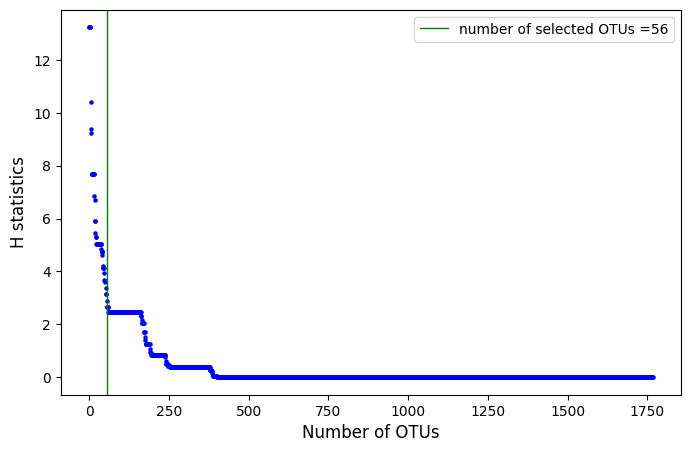

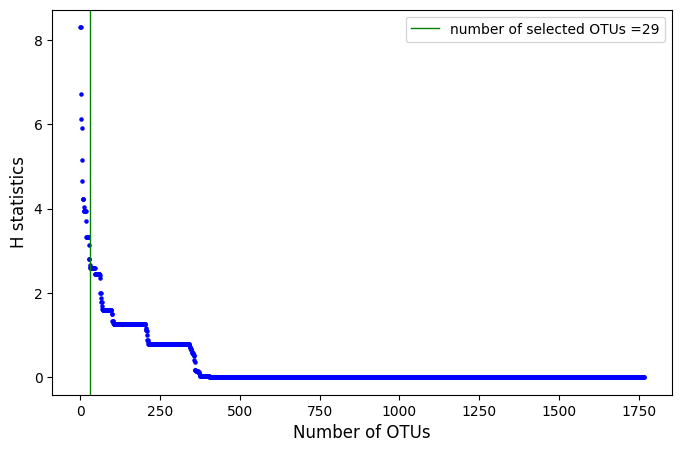

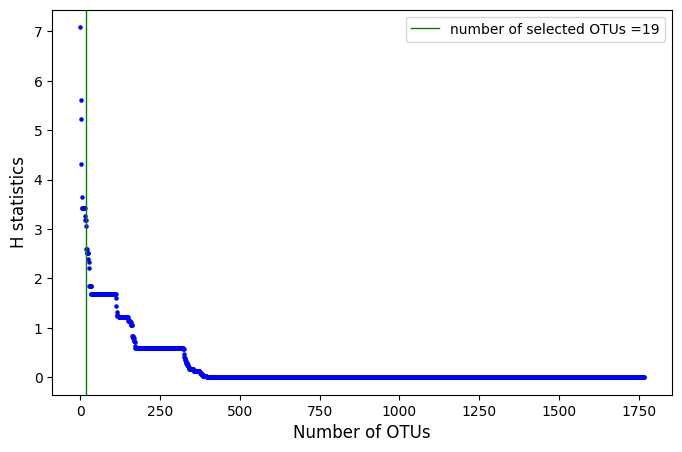

In [8]:
# select the OTUs
selected_list = []
for i in range(yList.shape[1]):
    selectedresult=FS.SelectMicro_fun(df,yList[:,i])
    selected_list.append(selectedresult)
selected_list[0].keys()

In [9]:
selectedOTU_index_list = [item['selected_indices'] for item in selected_list]
selectedASV_list = [item['selected_columnames'] for item in selected_list]
X_FS_list = [item['selected_data'] for item in selected_list]
data = selected_list[0]['relative_abundance_data']


### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [10]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]

In [11]:
selectedASV_list[0]

Index(['ASV66', 'ASV81', 'ASV85', 'ASV141', 'ASV148', 'ASV43', 'ASV73',
       'ASV38', 'ASV139', 'ASV154', 'ASV174', 'ASV181', 'ASV208', 'ASV216',
       'ASV263', 'ASV272', 'ASV94', 'ASV7', 'ASV3', 'ASV19', 'ASV45', 'ASV11',
       'ASV24', 'ASV91', 'ASV133', 'ASV146', 'ASV150', 'ASV159', 'ASV191',
       'ASV207', 'ASV225', 'ASV274', 'ASV315', 'ASV335', 'ASV338', 'ASV348',
       'ASV369', 'ASV384', 'ASV51', 'ASV5', 'ASV13', 'ASV18', 'ASV2', 'ASV30',
       'ASV104', 'ASV183', 'ASV231', 'ASV27', 'ASV8', 'ASV15', 'ASV26', 'ASV1',
       'ASV79', 'ASV54', 'ASV59', 'ASV32'],
      dtype='object')

In [12]:
X_lasso_list = []
X_lassoft_list =[]
selectedOTU_index_lasso_list = []
selectedOTU_index_lassoft_list = []

dict_cm_list = []

for i in range(yList.shape[1]):
    targetLabel=yList[:,i]
    print("The response variable and its counts are:")
    print(pd.Series(yList[:,i]).value_counts())
    
    X_FS = X_FS_list[i]
    
    X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
    X_lasso_list.append(X_lasso)
    selectedOTU_index_lasso_list.append(xlabel_lasso)

    X_lasso_ft,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)
    X_lassoft_list.append(X_lasso_ft)
    selectedOTU_index_lassoft_list.append(xlabel_lasso_ft)
    
    
    data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
                "Lasso_finetune":X_lasso_ft,
               #"Random":data
              }
    print(f'The shape of the original dataset is ',np.shape(data))
    print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
    print(f'The shape of the Lasso selected dataset is ',np.shape(X_lasso))
    print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))

    dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls,SMOTE=True)
    print(metric.metric_sum(dict_cm))
    dict_cm_list.append(dict_cm)


  

The response variable and its counts are:
Yes    42
No     17
Name: count, dtype: int64
Best alpha: 0.1
The shape of the original dataset is  (59, 1768)
The shape of the SelectMicro dataset is  (59, 56)
The shape of the Lasso selected dataset is  (59, 21)
The shape of the Lasso_finetune selected dataset is  (59, 14)


TBB Warning: The number of workers is currently limited to 0. The request for 47 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



                RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC  \
AllFeatures        0.780303  0.922917      0.746970  0.843750   
SelectMicro        0.896970  0.977778      0.698485  0.899306   
Lasso              0.915152  1.000000      0.965152  1.000000   
Lasso_finetune     0.913636  1.000000      0.963636  1.000000   

                CatBoost_Accuracy  CatBoost_AUC  NB_Accuracy    NB_AUC  
AllFeatures              0.845455      0.887037     0.863636  0.801389  
SelectMicro              0.878788      0.962269     0.933333  0.940278  
Lasso                    0.915152      0.977778     0.983333  0.988889  
Lasso_finetune           0.862121      0.961111     0.983333  0.988889  
                         Accuracy  Precision    Recall  Specification  \
AllFeatures_RF           0.779661   1.000000  0.235294       1.000000   
AllFeatures_SVM          0.745763   0.571429  0.470588       0.857143   
AllFeatures_CatBoost     0.847458   1.000000  0.470588       1.000000   
AllFeatures_NB   

In [13]:
X_FS_lasso_list = []
X_FS_lassoft_list =[]
selectedOTU_index_FS_lasso_list = []
selectedOTU_index_FS_lassoft_list = []

dict_cm_list2 = []

for i in range(yList.shape[1]):
    targetLabel=yList[:,i]
    print("The response variable and its counts are:")
    print(pd.Series(yList[:,i]).value_counts())
    
    X_FS = selected_list[i]['selected_data']
    
    X_FS_lasso,xlabel_FS_lasso = RunML_continue.LassoFeatureSelection(X_FS,targetLabel)# this is depend on the target variable(do not update here)
    X_FS_lasso_list.append(X_FS_lasso)
    selectedOTU_index_FS_lasso_list.append(xlabel_FS_lasso)

    X_FS_lasso_ft,xlabel_FS_lasso_ft  = RunML_continue.LassoFS_CV(X_FS,targetLabel)
    X_FS_lassoft_list.append(X_FS_lasso_ft)
    selectedOTU_index_FS_lassoft_list.append(xlabel_FS_lasso_ft)
    
    
    data_subset = {"FS_Lasso":X_FS_lasso,
                "FS_Lassofinetune":X_FS_lasso_ft}
    
    print(f'The shape of the FS_Lasso selected dataset is ',np.shape(X_FS_lasso))
    print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))

    dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls,SMOTE=True)
    print(metric.metric_sum(dict_cm))
    dict_cm_list2.append(dict_cm)


  

The response variable and its counts are:
Yes    42
No     17
Name: count, dtype: int64
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (59, 15)
The shape of the FS_Lasso_finetune selected dataset is  (59, 15)
                  RF_Accuracy  RF_AUC  SVM_Accuracy  SVM_AUC  \
FS_Lasso             0.930303     1.0      0.963636      1.0   
FS_Lassofinetune     0.930303     1.0      0.963636      1.0   

                  CatBoost_Accuracy  CatBoost_AUC  NB_Accuracy    NB_AUC  
FS_Lasso                   0.880303      0.975926     0.983333  0.988889  
FS_Lassofinetune           0.880303      0.975926     0.983333  0.988889  
                           Accuracy  Precision    Recall  Specification  \
FS_Lasso_RF                0.932203   1.000000  0.764706        1.00000   
FS_Lasso_SVM               0.966102   1.000000  0.882353        1.00000   
FS_Lasso_CatBoost          0.881356   1.000000  0.588235        1.00000   
FS_Lasso_NB                0.983051   0.944444  1.000000

In [14]:
selectedASV_list[0]

Index(['ASV66', 'ASV81', 'ASV85', 'ASV141', 'ASV148', 'ASV43', 'ASV73',
       'ASV38', 'ASV139', 'ASV154', 'ASV174', 'ASV181', 'ASV208', 'ASV216',
       'ASV263', 'ASV272', 'ASV94', 'ASV7', 'ASV3', 'ASV19', 'ASV45', 'ASV11',
       'ASV24', 'ASV91', 'ASV133', 'ASV146', 'ASV150', 'ASV159', 'ASV191',
       'ASV207', 'ASV225', 'ASV274', 'ASV315', 'ASV335', 'ASV338', 'ASV348',
       'ASV369', 'ASV384', 'ASV51', 'ASV5', 'ASV13', 'ASV18', 'ASV2', 'ASV30',
       'ASV104', 'ASV183', 'ASV231', 'ASV27', 'ASV8', 'ASV15', 'ASV26', 'ASV1',
       'ASV79', 'ASV54', 'ASV59', 'ASV32'],
      dtype='object')

In [15]:
selectedOTU_index_FS_lassoft_list

[array([ 1,  2,  3,  4, 12, 13, 16, 17, 25, 28, 30, 32, 33, 34, 48]),
 array([ 1,  3,  7,  8, 10, 12, 13, 15, 16, 17, 19, 20, 21, 26]),
 array([ 1,  2,  3,  5,  7, 10, 11, 12, 13, 14, 16, 17])]

In [16]:
selectedOTU_index_FS_lassoft_list[0]

array([ 1,  2,  3,  4, 12, 13, 16, 17, 25, 28, 30, 32, 33, 34, 48])

## compare the first 20 index

In [17]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Keep only the first 20 elements

entries=20

selectedOTU_index_15_list=[arr[:entries] for arr in selectedOTU_index_list]

selectedASVs20_list = []
for i in range(yList.shape[1]):
    selectedASVs = ASVs[selectedOTU_index_15_list[i]]
    selectedASVs20_list.append(selectedASVs)

Validation passed: Dimensions are correct.
Burned= 42, Not Burned = 17
       OTU  presence_pos  presence_neg
0    ASV66      0.000000      0.294118
1    ASV81      0.000000      0.294118
2    ASV85      0.000000      0.294118
3   ASV141      0.000000      0.294118
4   ASV148      0.000000      0.294118
5    ASV43      0.000000      0.235294
6    ASV73      0.023810      0.294118
7    ASV38      0.047619      0.352941
8   ASV139      0.000000      0.176471
9   ASV154      0.000000      0.176471
10  ASV174      0.000000      0.176471
11  ASV181      0.000000      0.176471
12  ASV208      0.000000      0.176471
13  ASV216      0.000000      0.176471
14  ASV263      0.000000      0.176471
15  ASV272      0.000000      0.176471
16   ASV94      0.023810      0.235294
17    ASV7      0.452381      0.117647
18    ASV3      0.285714      0.000000
19   ASV19      0.285714      0.000000


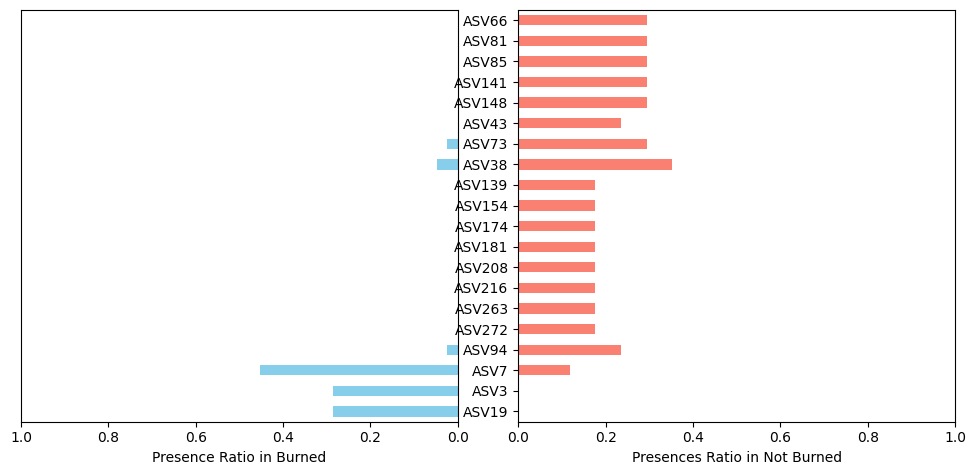

Validation passed: Dimensions are correct.
Burned= 42, Not Burned = 17
       OTU  presence_pos  presence_neg
0     ASV7      0.452381      0.117647
1     ASV8      0.119048      0.294118
2    ASV81      0.000000      0.294118
3    ASV85      0.000000      0.294118
4    ASV94      0.023810      0.235294
5   ASV141      0.000000      0.294118
6   ASV146      0.000000      0.117647
7   ASV148      0.000000      0.294118
8   ASV208      0.000000      0.176471
9   ASV216      0.000000      0.176471
10  ASV225      0.000000      0.117647
11  ASV315      0.000000      0.117647
12  ASV335      0.000000      0.117647
13  ASV338      0.000000      0.117647


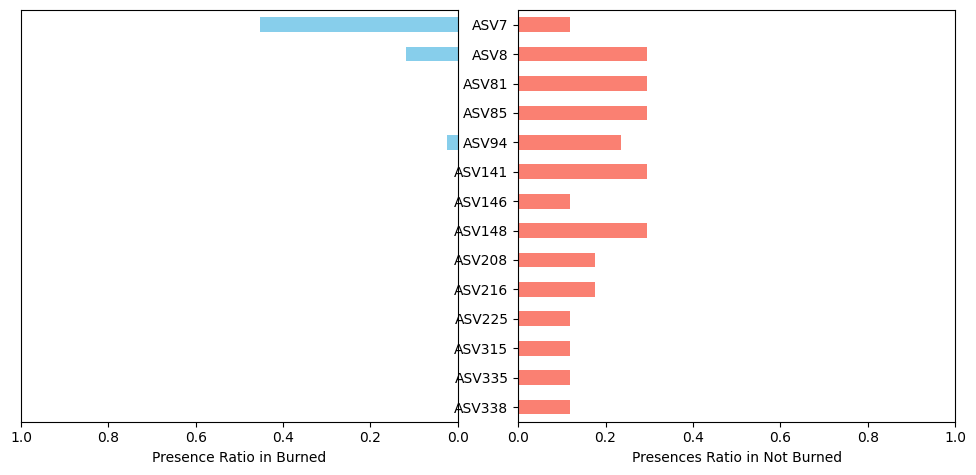

Validation passed: Dimensions are correct.
Burned= 42, Not Burned = 17
       OTU  presence_pos  presence_neg
0    ASV81      0.000000      0.294118
1    ASV85      0.000000      0.294118
2   ASV141      0.000000      0.294118
3   ASV148      0.000000      0.294118
4   ASV208      0.000000      0.176471
5   ASV216      0.000000      0.176471
6    ASV94      0.023810      0.235294
7     ASV7      0.452381      0.117647
8   ASV146      0.000000      0.117647
9   ASV191      0.000000      0.117647
10  ASV225      0.000000      0.117647
11  ASV315      0.000000      0.117647
12  ASV335      0.000000      0.117647
13  ASV338      0.000000      0.117647
14    ASV8      0.119048      0.294118


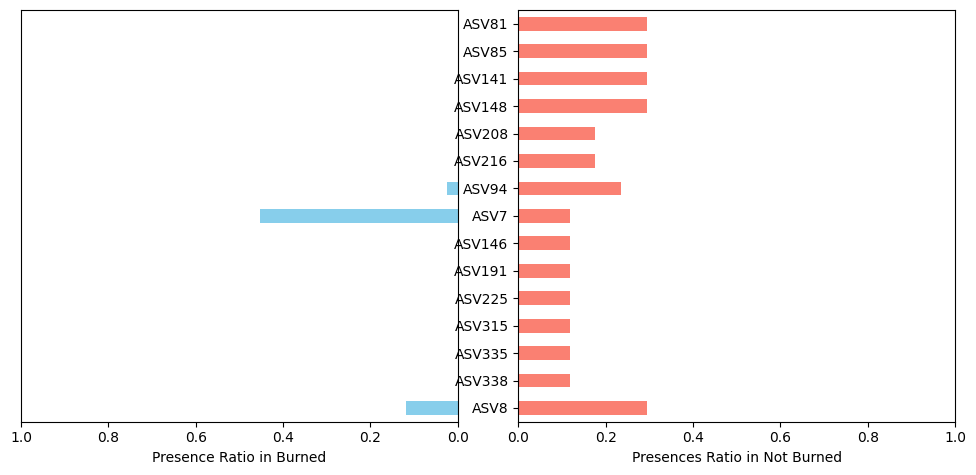

In [18]:
targetLabel=burn_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[0]],yList[:,0],selectedASVs20_list[0],
                     posLabel="Yes",posText="Burned",negText="Not Burned")
FS.plotPresenseRatio(X_lassoft_list[0],yList[:,0],ASVs[selectedOTU_index_lassoft_list[0]],
                     posLabel="Yes",posText="Burned",negText="Not Burned")

FS.plotPresenseRatio(X_FS_list[0][:,selectedOTU_index_FS_lassoft_list[0]],yList[:,0],selectedASV_list[0][selectedOTU_index_FS_lassoft_list[0]],
                     posLabel="Yes",posText="Burned",negText="Not Burned")

Validation passed: Dimensions are correct.
Natural= 26, Urban = 33
       OTU  presence_pos  presence_neg
0    ASV72      0.230769      0.000000
1   ASV111      0.230769      0.000000
2    ASV26      0.269231      0.030303
3    ASV79      0.000000      0.212121
4    ASV18      0.307692      0.060606
5    ASV73      0.000000      0.181818
6    ASV39      0.269231      0.060606
7    ASV52      0.000000      0.151515
8    ASV81      0.000000      0.151515
9   ASV148      0.000000      0.151515
10   ASV95      0.192308      0.030303
11   ASV37      0.115385      0.000000
12   ASV70      0.115385      0.000000
13   ASV99      0.115385      0.000000
14  ASV129      0.115385      0.000000
15  ASV138      0.115385      0.000000
16  ASV179      0.115385      0.000000
17  ASV180      0.115385      0.000000
18   ASV38      0.038462      0.212121
19  ASV104      0.000000      0.121212


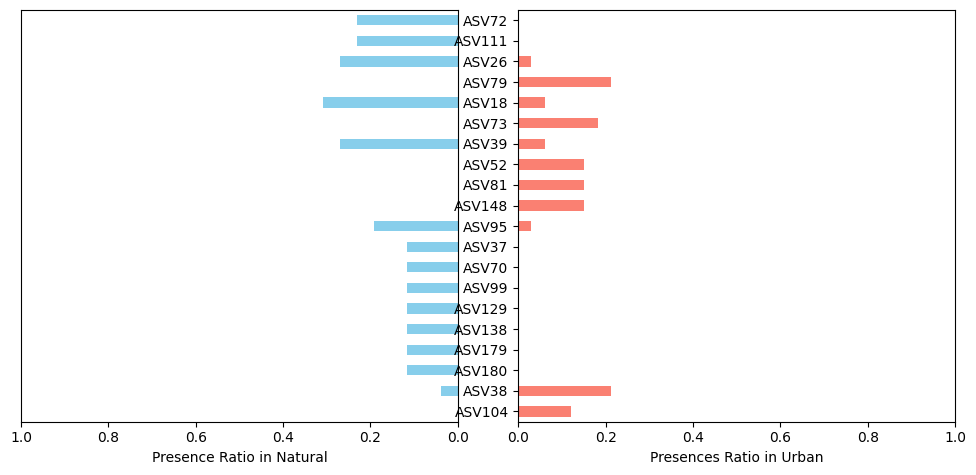

Validation passed: Dimensions are correct.
Natural= 26, Urban = 33
       OTU  presence_pos  presence_neg
0    ASV18      0.307692      0.060606
1    ASV52      0.000000      0.151515
2    ASV76      0.115385      0.060606
3    ASV79      0.000000      0.212121
4    ASV81      0.000000      0.151515
5    ASV95      0.192308      0.030303
6   ASV111      0.230769      0.000000
7   ASV114      0.000000      0.121212
8   ASV138      0.115385      0.000000
9   ASV179      0.115385      0.000000
10  ASV225      0.076923      0.000000


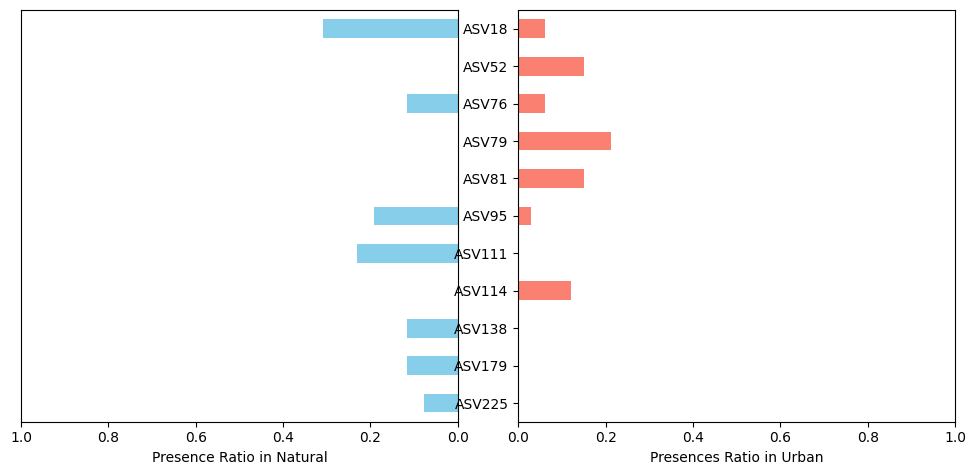

Validation passed: Dimensions are correct.
Natural= 26, Urban = 33
       OTU  presence_pos  presence_neg
0   ASV111      0.230769      0.000000
1    ASV79      0.000000      0.212121
2    ASV52      0.000000      0.151515
3    ASV81      0.000000      0.151515
4    ASV95      0.192308      0.030303
5    ASV70      0.115385      0.000000
6    ASV99      0.115385      0.000000
7   ASV138      0.115385      0.000000
8   ASV179      0.115385      0.000000
9   ASV180      0.115385      0.000000
10  ASV104      0.000000      0.121212
11  ASV110      0.000000      0.121212
12  ASV114      0.000000      0.121212
13   ASV15      0.230769      0.060606


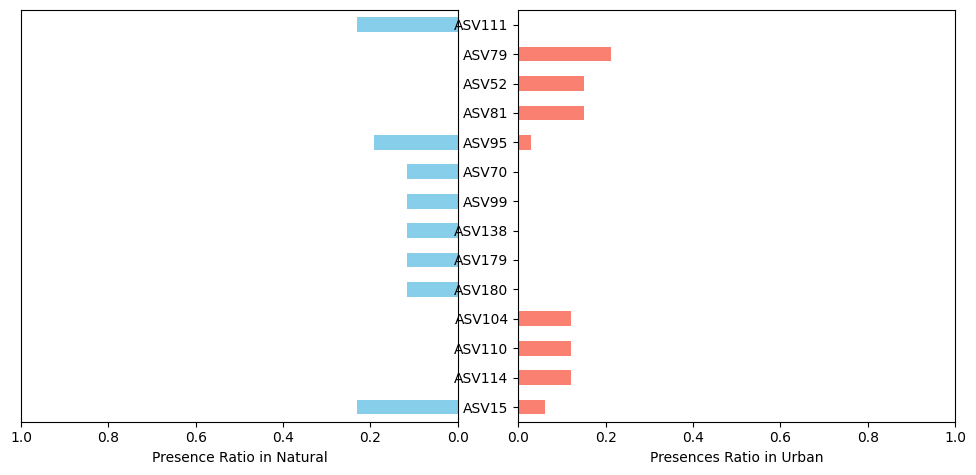

In [19]:
targetLabel=un_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[1]],yList[:,1],selectedASVs20_list[1],
                     posLabel="Natural",posText="Natural",negText="Urban")

FS.plotPresenseRatio(X_lassoft_list[1],yList[:,1],ASVs[selectedOTU_index_lassoft_list[1]],
                    posLabel="Natural",posText="Natural",negText="Urban")
FS.plotPresenseRatio(X_FS_list[1][:,selectedOTU_index_FS_lassoft_list[1]],yList[:,1],selectedASV_list[1][selectedOTU_index_FS_lassoft_list[1]],
                     posLabel="Natural",posText="Natural",negText="Urban")

Validation passed: Dimensions are correct.
Annual= 22, Perennial = 37
       OTU  presence_pos  presence_neg
0   ASV237      0.181818      0.000000
1    ASV15      0.272727      0.054054
2   ASV310      0.136364      0.000000
3    ASV61      0.181818      0.027027
4    ASV53      0.227273      0.054054
5    ASV65      0.090909      0.000000
6   ASV122      0.090909      0.000000
7   ASV161      0.090909      0.000000
8   ASV227      0.090909      0.000000
9   ASV241      0.090909      0.000000
10  ASV250      0.090909      0.000000
11  ASV270      0.090909      0.000000
12  ASV271      0.090909      0.000000
13  ASV276      0.090909      0.000000
14  ASV304      0.090909      0.000000
15    ASV3      0.318182      0.135135
16   ASV66      0.000000      0.135135
17   ASV85      0.000000      0.135135
18   ASV27      0.090909      0.297297


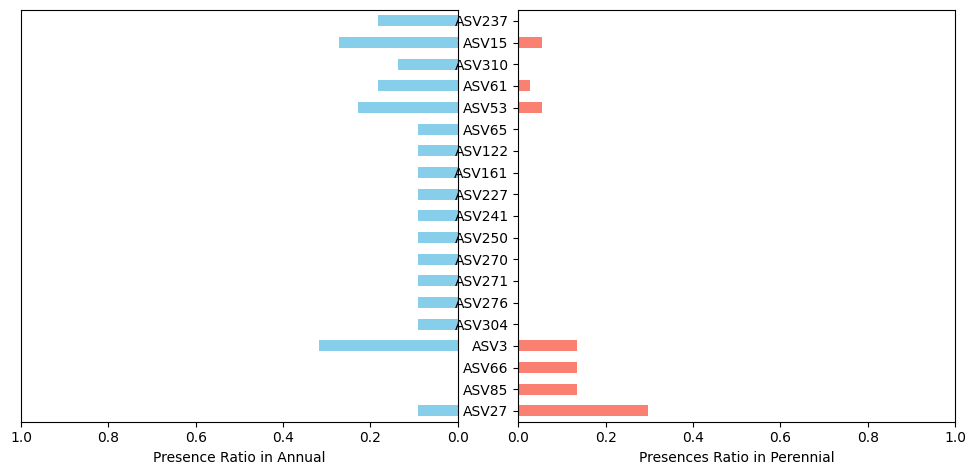

Validation passed: Dimensions are correct.
Annual= 22, Perennial = 37
      OTU  presence_pos  presence_neg
0   ASV15      0.272727      0.054054
1   ASV61      0.181818      0.027027
2  ASV250      0.090909      0.000000
3  ASV270      0.090909      0.000000
4  ASV271      0.090909      0.000000
5  ASV276      0.090909      0.000000
6  ASV310      0.136364      0.000000


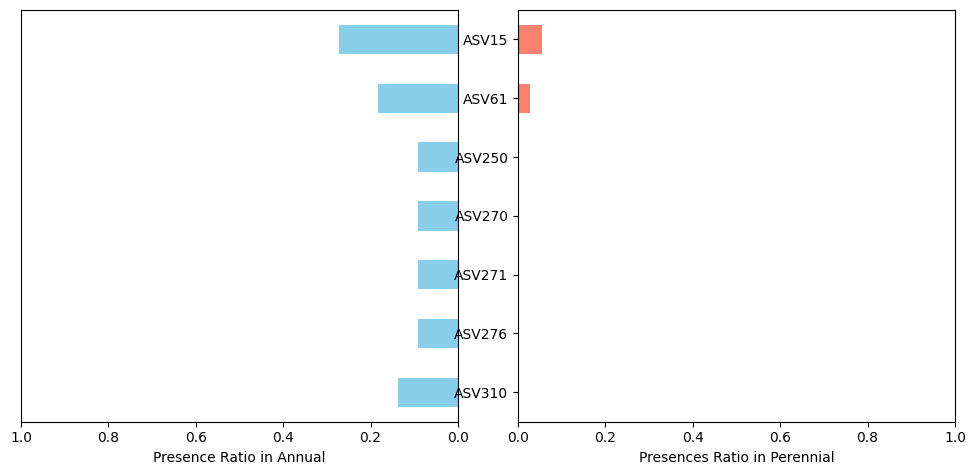

Validation passed: Dimensions are correct.
Annual= 22, Perennial = 37
       OTU  presence_pos  presence_neg
0    ASV15      0.272727      0.054054
1   ASV310      0.136364      0.000000
2    ASV61      0.181818      0.027027
3    ASV65      0.090909      0.000000
4   ASV161      0.090909      0.000000
5   ASV250      0.090909      0.000000
6   ASV270      0.090909      0.000000
7   ASV271      0.090909      0.000000
8   ASV276      0.090909      0.000000
9   ASV304      0.090909      0.000000
10   ASV66      0.000000      0.135135
11   ASV85      0.000000      0.135135


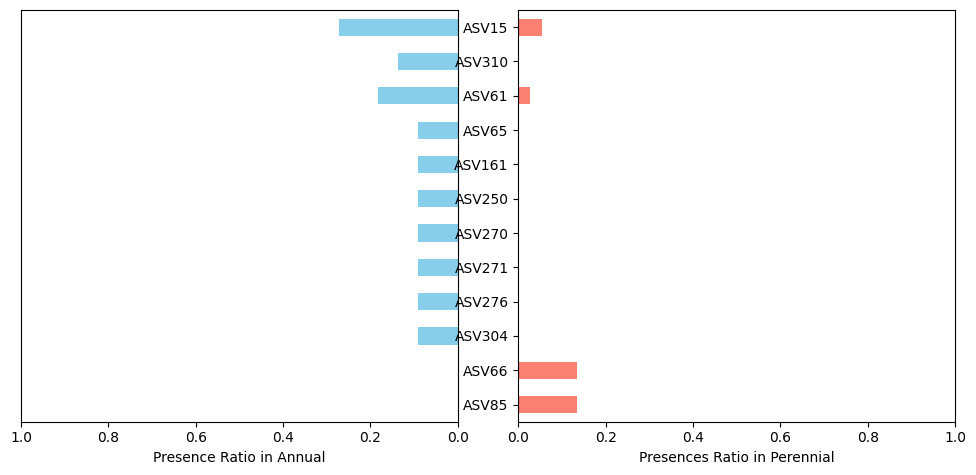

In [20]:
targetLabel=duration_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[2]],yList[:,2],selectedASVs20_list[2],
                    posLabel="Annual",posText="Annual",negText="Perennial")
FS.plotPresenseRatio(X_lassoft_list[2],yList[:,2],ASVs[selectedOTU_index_lassoft_list[2]],
                    posLabel="Annual",posText="Annual",negText="Perennial")
FS.plotPresenseRatio(X_FS_list[2][:,selectedOTU_index_FS_lassoft_list[2]],yList[:,2],selectedASV_list[2][selectedOTU_index_FS_lassoft_list[2]],
                     posLabel="Annual",posText="Annual",negText="Perennial")

In [21]:
X_FS_list[2][:,selectedOTU_index_FS_lasso_list[2]].shape

(59, 13)

In [22]:
len(selectedASV_list[2][selectedOTU_index_FS_lassoft_list[2]])

12

In [23]:
len(selectedOTU_index_FS_lasso_list[2])

13

In [24]:
selectedASV_list[2]

Index(['ASV237', 'ASV15', 'ASV310', 'ASV61', 'ASV53', 'ASV65', 'ASV122',
       'ASV161', 'ASV227', 'ASV241', 'ASV250', 'ASV270', 'ASV271', 'ASV276',
       'ASV304', 'ASV3', 'ASV66', 'ASV85', 'ASV27'],
      dtype='object')

In [25]:
selectedOTU_index_FS_lassoft_list[2]

array([ 1,  2,  3,  5,  7, 10, 11, 12, 13, 14, 16, 17])